In [1]:
!pip3 install tensorflow
!pip3 install kagglehub


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from tensorflow import keras
from keras import layers

c:\Users\victo\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\victo\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\victo\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framewo

In [3]:
file_path = os.path.join("wre.us.txt")
df = pd.read_csv(file_path)

# Extraer encabezados
header = df.columns.tolist()
price = df["Close"].to_numpy()             
raw_data = df.iloc[:, 1:].to_numpy() 


# Punto 1
## Parsing Data



In [4]:

price_high = df["High"].to_numpy()
price_low = df["Low"].to_numpy()
price = (price_high + price_low) / 2

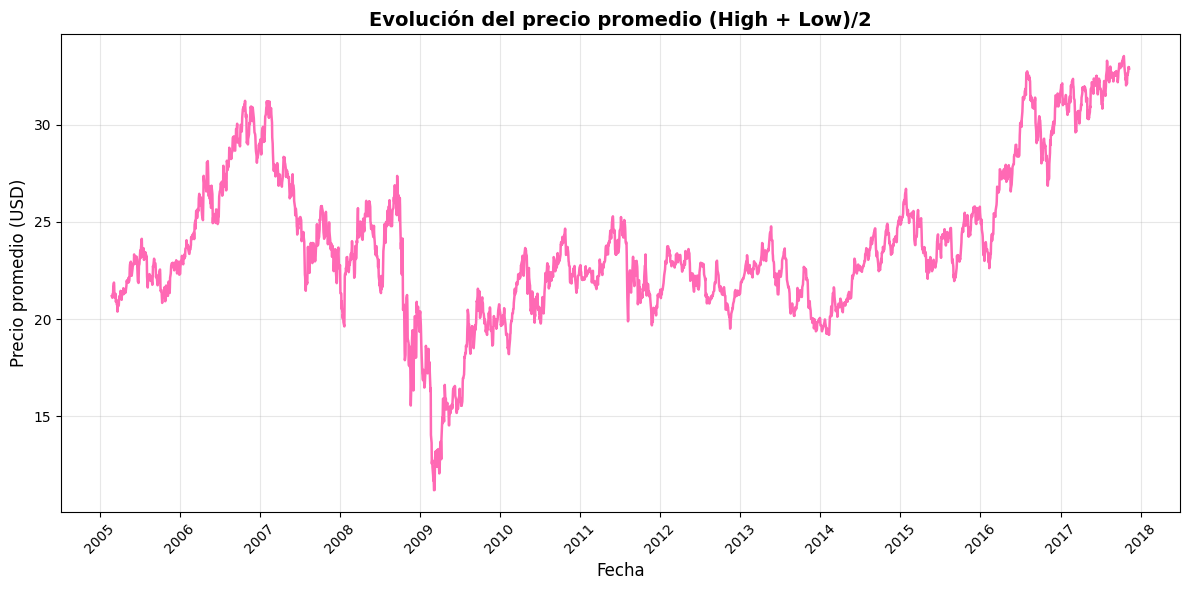

In [5]:


# Convertir la columna 'Date' a formato de fecha
df["Date"] = pd.to_datetime(df["Date"])

plt.figure(figsize=(12,6))
plt.plot(df["Date"], price, color='hotpink', linewidth=1.8)

# Título y etiquetas
plt.title("Evolución del precio promedio (High + Low)/2", fontsize=14, weight='bold')
plt.xlabel("Fecha", fontsize=12)
plt.ylabel("Precio promedio (USD)", fontsize=12)

# Formato del eje X para fechas
plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))       
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y")) 

# Rotar etiquetas y ajustar estilo
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# Normalization

In [6]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 1600
num_val_samples: 800
num_test_samples: 801


In [7]:
print("¿Hay NaN en raw_data?:", np.isnan(raw_data).any())
print("¿Hay inf en raw_data?:", np.isinf(raw_data).any())
std = raw_data[:num_train_samples].std(axis=0)
print("Mínimo std:", np.min(std))

¿Hay NaN en raw_data?: False
¿Hay inf en raw_data?: False
Mínimo std: 0.0


In [8]:

mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)

# Verificar columnas con std = 0
constant_cols = np.where(std == 0)[0]
column_names = df.columns[1:]
print("Columnas constantes:", column_names[constant_cols])
print("Número de columnas constantes:", len(constant_cols))

std[std == 0] = 1 
raw_data /= std


Columnas constantes: Index(['OpenInt'], dtype='object')
Número de columnas constantes: 1


### Clase Redes

In [9]:


class ModelBuilder:
    def __init__(self, raw_data, price, sequence_length):
        self.raw_data = raw_data
        self.price = price
        self.sequence_length = sequence_length
        self.models = {}
        self.histories = {}
        self.train_dataset = None
        self.val_dataset = None
        self.test_dataset = None

 
    def create_datasets(self, delay, batch_size, sampling_rate, num_train_samples, num_val_samples):
        self.train_dataset = keras.utils.timeseries_dataset_from_array(
            data=self.raw_data[:-delay],
            targets=self.price[delay:],
            sequence_length=self.sequence_length,
            sampling_rate=sampling_rate,
            shuffle=False,
            batch_size=batch_size,
            start_index=0,
            end_index=num_train_samples
        )

        self.val_dataset = keras.utils.timeseries_dataset_from_array(
            data=self.raw_data[:-delay],
            targets=self.price[delay:],
            sequence_length=self.sequence_length,
            sampling_rate=sampling_rate,
            shuffle=False,
            batch_size=batch_size,
            start_index=num_train_samples,
            end_index=num_train_samples + num_val_samples
        )

        self.test_dataset = keras.utils.timeseries_dataset_from_array(
            data=self.raw_data[:-delay],
            targets=self.price[delay:],
            sequence_length=self.sequence_length,
            sampling_rate=sampling_rate,
            shuffle=False,
            batch_size=batch_size,
            start_index=num_train_samples + num_val_samples
        )

        return self.train_dataset, self.val_dataset, self.test_dataset

   
    def create_LSTM_model(self, num_neurons, epochs, dropout_rate=0.0, use_recurrent_dropout=False, name_model="LSTM"):
        inputs = keras.Input(shape=(self.sequence_length, self.raw_data.shape[-1]))
        x = layers.LSTM(num_neurons, recurrent_dropout=dropout_rate if use_recurrent_dropout else 0)(inputs)
        outputs = layers.Dense(1)(x)
        model = keras.Model(inputs, outputs)

        callbacks = [keras.callbacks.ModelCheckpoint(f"{name_model}.keras", save_best_only=True)]
        model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
        history = model.fit(self.train_dataset, epochs=epochs, validation_data=self.val_dataset, callbacks=callbacks)

        model = keras.models.load_model(f"{name_model}.keras")
        print(f"Test MAE: {model.evaluate(self.test_dataset)[1]:.2f}")
        self.models[name_model] = model
        self.histories[name_model] = history
        return model, history

 
    def create_GRU_model(self, num_neurons, epochs, dropout_rate=0.0, use_recurrent_dropout=False, name_model="GRU"):
        inputs = keras.Input(shape=(self.sequence_length, self.raw_data.shape[-1]))
        x = layers.GRU(num_neurons, recurrent_dropout=dropout_rate if use_recurrent_dropout else 0)(inputs)
        outputs = layers.Dense(1)(x)
        model = keras.Model(inputs, outputs)

        callbacks = [keras.callbacks.ModelCheckpoint(f"{name_model}.keras", save_best_only=True)]
        model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
        history = model.fit(self.train_dataset, epochs=epochs, validation_data=self.val_dataset, callbacks=callbacks)

        model = keras.models.load_model(f"{name_model}.keras")
        print(f"Test MAE: {model.evaluate(self.test_dataset)[1]:.2f}")
        self.models[name_model] = model
        self.histories[name_model] = history
        return model, history

  
    def create_stacked_GRU(self, num_l1, num_l2, epochs, name_model="Stacked_GRU"):
        num_features = self.raw_data.shape[-1]
        output_dim = 1

        model = tf.keras.Sequential([
            tf.keras.layers.GRU(num_l1, return_sequences=True, input_shape=(self.sequence_length, num_features)),
            tf.keras.layers.GRU(num_l2, return_sequences=False),
            tf.keras.layers.Dense(output_dim, activation='linear')
        ])

        callbacks = [keras.callbacks.ModelCheckpoint(f"{name_model}.keras", save_best_only=True)]
        model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
        history = model.fit(self.train_dataset, epochs=epochs, validation_data=self.val_dataset, callbacks=callbacks)

        model = keras.models.load_model(f"{name_model}.keras")
        print(f"Test MAE: {model.evaluate(self.test_dataset)[1]:.2f}")
        self.models[name_model] = model
        self.histories[name_model] = history
        return model, history
    
    
    def graph_history(self,history):
        loss = history.history["mae"]
        val_loss = history.history["val_mae"]
        epochs = range(1, len(loss) + 1)
        plt.figure()
        plt.plot(epochs, loss, "lightpink", label="Training MAE")
        plt.plot(epochs, val_loss, "purple", label="Validation MAE")
        plt.title("Training and validation MAE (LSTM)")
        plt.legend()
        plt.show()
        
        
    
    def graph_prediction(self,y_true, predictions):
        # Plotting
        plt.figure(figsize=(10, 5))
        plt.plot(y_true[20:40], label='True Values', color='pink')
        plt.plot(predictions[20:40], label='Predicted Values', color='purple')
        plt.title('LSTM Predictions vs True Values')
        plt.xlabel('Date')
        plt.ylabel('Value')
        plt.legend()
        plt.show()


 
    def predict(self, model):
        
        if model is None:
            raise ValueError(f"Modelo {model} no existe.")
        
        y_true = np.concatenate([y for x, y in self.test_dataset], axis=0)
        predictions = model.predict(self.test_dataset)
        return y_true, predictions

   



# Punto 2

In [10]:
builder = ModelBuilder(raw_data, price, sequence_length=30)

# Crear datasets
builder.create_datasets(delay=1, batch_size=32, sampling_rate=1,
                        num_train_samples=num_train_samples,
                        num_val_samples=num_val_samples)


(<_BatchDataset element_spec=(TensorSpec(shape=(None, None, 6), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_BatchDataset element_spec=(TensorSpec(shape=(None, None, 6), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_BatchDataset element_spec=(TensorSpec(shape=(None, None, 6), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [11]:
model_lstm, hist_lstm = builder.create_LSTM_model(num_neurons=64, epochs=100,
                                                  dropout_rate=0.2, use_recurrent_dropout=True,
                                                  name_model="LSTM_64")




Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 310.4838 - mae: 16.8950 - val_loss: 113.7042 - val_mae: 10.5950
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 111.1553 - mae: 9.6828 - val_loss: 46.4106 - val_mae: 6.7044
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 55.4224 - mae: 6.5733 - val_loss: 16.8218 - val_mae: 3.9190
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 27.8411 - mae: 4.3667 - val_loss: 4.0739 - val_mae: 1.7098
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 14.0371 - mae: 2.8345 - val_loss: 1.4621 - val_mae: 1.0089
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 8.8484 - mae: 2.1543 - val_loss: 1.6729 - val_mae: 1.0719
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 6.8166 - mae: 1.8761 - val_loss: 0.7904 - val_mae: 0.7445
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 5.0759 - mae: 1.6153 - val_loss: 0.5198 - val_mae: 0.5877
Epoch 9/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 2

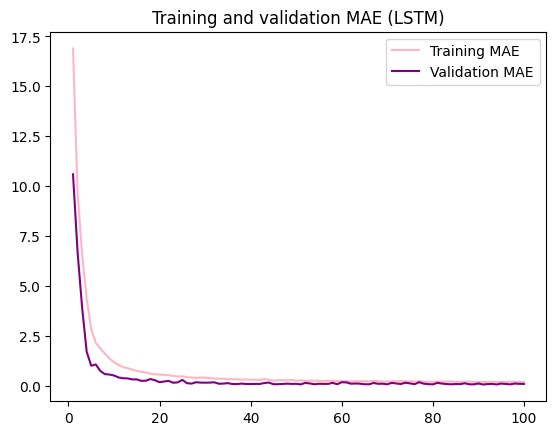

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


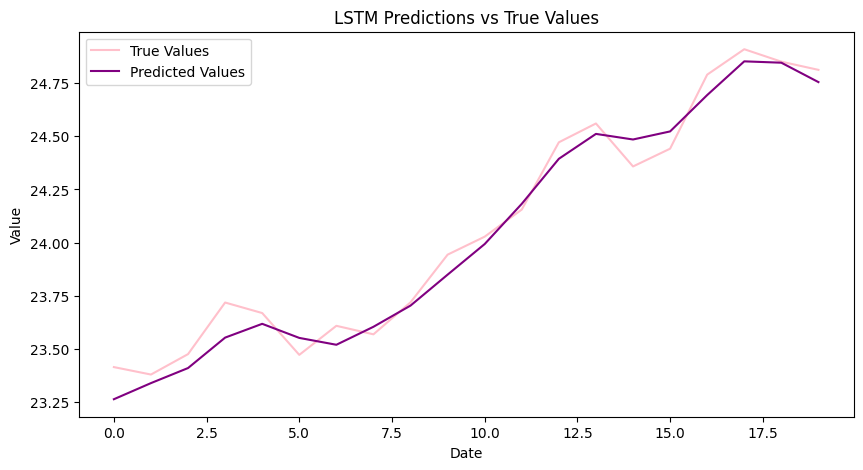

In [12]:
builder.graph_history(hist_lstm)
y_true,predictions = builder.predict(model_lstm)
builder.graph_prediction(y_true,predictions)


# Punto 3

In [13]:
model_gru, hist_gru = builder.create_GRU_model(num_neurons=32, epochs=100,
                                               dropout_rate=0.2, use_recurrent_dropout=True,
                                               name_model="GRU_32")

Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 513.8279 - mae: 22.4405 - val_loss: 431.2637 - val_mae: 20.7380
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 345.3193 - mae: 18.2570 - val_loss: 206.8579 - val_mae: 14.3336
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 221.9781 - mae: 14.4314 - val_loss: 149.5452 - val_mae: 12.1692
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 168.7218 - mae: 12.4038 - val_loss: 111.9231 - val_mae: 10.5100
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 130.7823 - mae: 10.7605 - val_loss: 81.5178 - val_mae: 8.9472
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 99.7481 - mae: 9.2538 - val_loss: 56.7178 - val_mae: 7.4332
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 74.3062 - mae: 7.8272 - val_loss: 37.0877 - val_mae: 5.9685
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 54.5407 - mae: 6.5666 - val_loss: 22.3635 - val_mae: 4.5715
Epoch 9/100
50/50 ━━━━

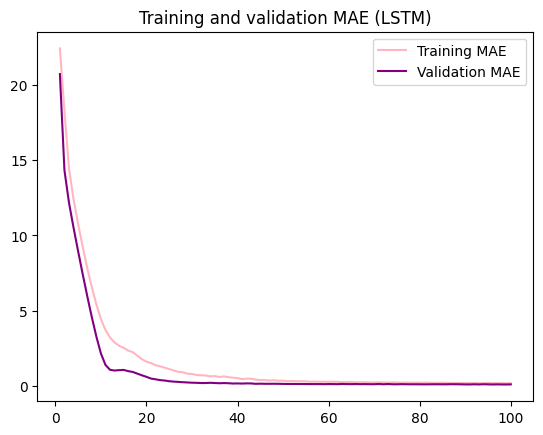

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


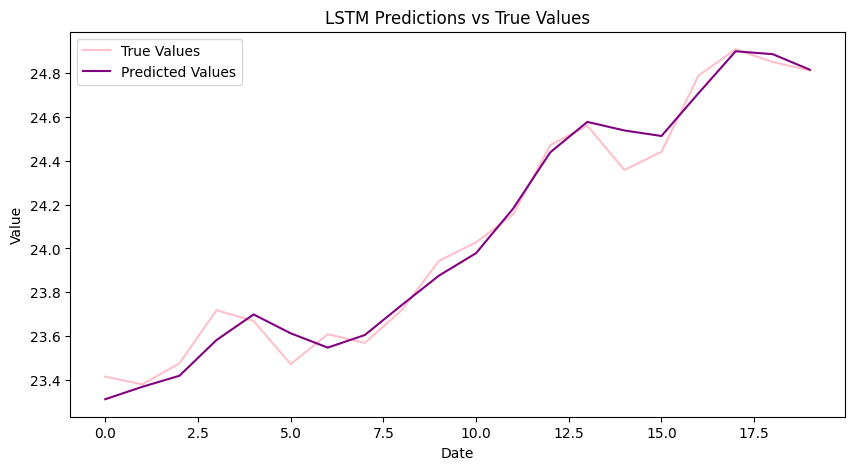

In [14]:
builder.graph_history(hist_gru)
y_trueG,predictionsG = builder.predict(model_gru)
builder.graph_prediction(y_trueG,predictionsG)


# Punto 4

In [15]:
model_stack, hist_stack = builder.create_stacked_GRU(num_l1=64, num_l2=32, epochs=50,
                                                     name_model="Stacked_GRU")

Epoch 1/50


c:\Users\victo\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - loss: 365.7803 - mae: 18.7169 - val_loss: 179.0792 - val_mae: 13.3273
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 213.7029 - mae: 14.1337 - val_loss: 133.3637 - val_mae: 11.4848
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 151.6942 - mae: 11.6860 - val_loss: 98.6570 - val_mae: 9.8586
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 117.2090 - mae: 10.1223 - val_loss: 70.7691 - val_mae: 8.3249
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 88.7388 - mae: 8.6640 - val_loss: 48.1493 - val_mae: 6.8326
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 65.4771 - mae: 7.2875 - val_loss: 30.5478 - val_mae: 5.3928
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 47.2264 - mae: 6.0629 - val_loss: 17.7224 - val_mae: 4.0320
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 33.7405 - mae: 4.9862 - val_loss: 9.2544 - val_mae: 2.7909
Epoch 9/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/st

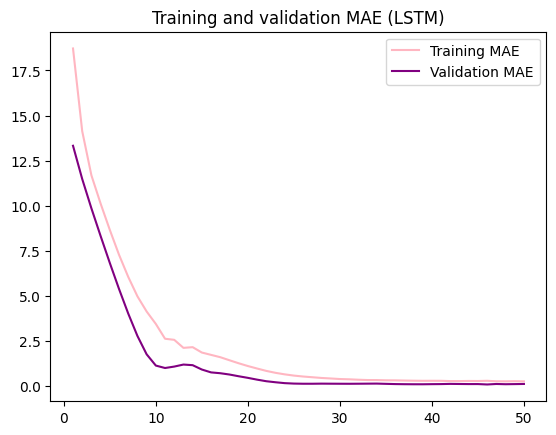

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


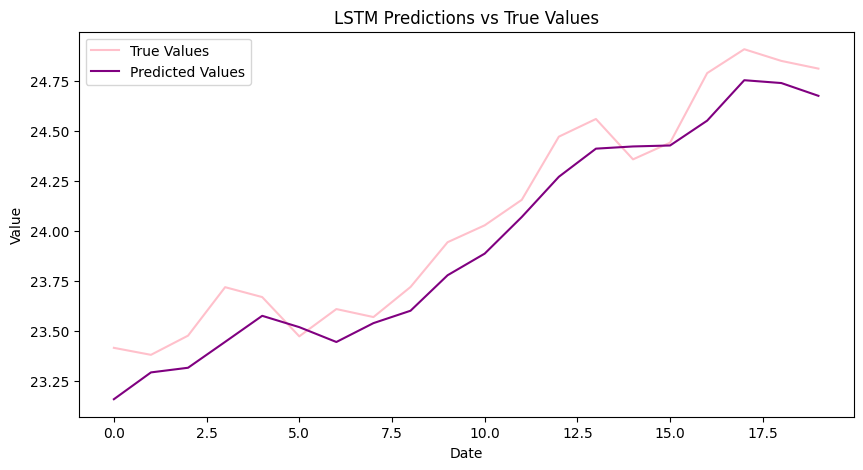

In [16]:
builder.graph_history(hist_stack)
y_trueS,predictionsS = builder.predict(model_stack)
builder.graph_prediction(y_trueS,predictionsS)
